<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">


*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving *scale* to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the final aeroplane we will progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*In this notebook we build the boundaries associated with the cruise and service ceiling constraints.*

## THE CRUISE SPEED CONSTRAINT

From the condition that for steady, level cruising flight thrust must equal drag. Developing drag, as before, as the sum of a zero lift component and a lift-induced component, we can write:

$$T=D=\frac{1}{2}\rho V^2S C_\mathrm{D} = \frac{1}{2}\rho V^2S\left(C_\mathrm{Dmin} + \frac{C_\mathrm{L}^2}{\pi \mathrm{AR} e} \right)$$

Since lift must equal weight, we can extract the lift coefficient from the lift equation and write it in terms of the weight $W$ as $C_\mathrm{L}=2W/\rho V^2 S$. Inserting this into the above and rearranging yields:

$$\frac{T}{W} = \frac{\frac{1}{2}\rho V^2S C_\mathrm{Dmin}}{W} + \frac{2S}{\pi\,\mathrm{AR}\,e\,\rho\,V^2\,W}\left(\frac{W}{S} \right)^2  $$

$$\frac{T}{W} = \frac{\frac{1}{2}\rho V^2 C_\mathrm{Dmin}}{(W/S)}  +\frac{2}{\pi\,\mathrm{AR}\,e\,\rho\,V^2\,}\left(\frac{W}{S} \right)   $$

Writing in terms of the dynamic pressure $q$ and the induced drag factor $k$:

$$ \frac{T}{W} = \frac{q}{(W/S)}C_\mathrm{Dmin} + \frac{k}{q}\left(\frac{W}{S}\right)  $$


It may be noted that this is basically the rate of climb constraint with the rate of climb set to zero, though, of course, $q$ will be different - it will be the $q$ corresponding to the desired cruise speed.

Note also that the cruise speed (which plugs into the $q$ above) is a true airspeed (TAS), standing in as a surrogate for ground speed (on the zero wind assumption) - after all, when we specify a cruise speed requirement for an aeroplane, we are interested in how long it takes to get from A to B, not what number is displayed on its airspeed indicator.

In the case of internal combustion engines the weight at the beginning of the cruise may be less than the take-off weight and so the W/S plugged into the equation above should actually be $W_\mathrm{cruise}/S$ and the resulting thrust to weight ratio is actually $T/W_\mathrm{cruise}$. If we define a cruise weight fraction $f_\mathrm{W} = W_\mathrm{cruise}\,/\,\mathrm{MTOW}$, then, if we wish to plot this constraint on the same chart as the others, both the input wing loading and the resulting thrust to weight ratio must be multiplied by $f_\mathrm{W}$. We add $f_W$ to the `wfract` dictionary (which contains such weight fractions for each constraint); this, in turn, must be added to the `designdefinition` dictionary as an entry against the `weightfractions` key.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as co
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

In [3]:
designbrief = {'rwyelevation_m':1000, 'groundrun_m':1200, \
               'stloadfactor': 2, 'turnalt_m': 5000, 'turnspeed_ktas': 300, \
               'climbalt_m': 1000, 'climbspeed_ktas': 250, 'climbrate_fpm': 1000, \
               'cruisealt_m': 15000, 'cruisespeed_ktas': 445}

wfract = {'turn': 1.0, 'climb': 1.0, 'cruise': 0.85, 'servceil': 0.85}

designdefinition = {'aspectratio':7.3, 'sweep_le_deg':10, 'sweep_mt_deg':8, 'bpr':3.9, 'tr':1.05, 'weightfractions':wfract} 

designperformance = {'CDTO':0.04, 'CLTO':0.9, 'CLmaxTO':1.6, 'mu_R':0.02, 'CDminclean':0.02}
designatm = at.Atmosphere()

concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm)

The `designbrief` dictionary above specifies the cruise speed, but the cruise Mach number could be specified too. In any case, the conversion is simple either way, using ADRpy's `mach` method associated with the `Atmosphere` object:

In [9]:
cruisemach = designatm.mach(co.kts2mps(designbrief['cruisespeed_ktas']), designbrief['cruisealt_m'])
print(cruisemach)

0.7758435318999249


In [10]:
wingloadinglist_pa = np.arange(2000, 5000, 10)
twratio = concept.twrequired_crs(wingloadinglist_pa)

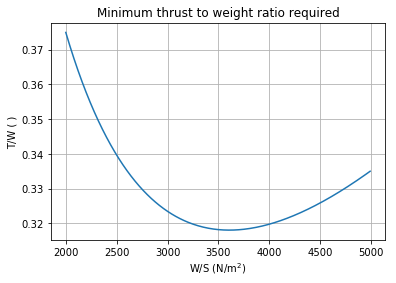

In [11]:
plt.plot(wingloadinglist_pa, twratio)
plt.ylabel("T/W ( )")
plt.xlabel("W/S (N/m$^2$)")
plt.title("Minimum thrust to weight ratio required")
plt.grid(True)
plt.show()

## THE SERVICE CEILING CONSTRAINT

### The best rate of climb airspeed

The service ceiling of an aircraft is defined as the maximum altitude at which the aircraft is able to attain a specified minimal rate of climb - usually 100fpm (0.508m/s) -- when flying at best climbing speed. This means that we can simply use the rate of climb constraint formulation here too, with the caveat that the accuracy of the ceiling constraint calculation depends on our estimate of the best climb speed. 

For propeller aircraft Gudmundsson (page 833, Equation 18-27) offers the following estimate of the best rate of climb speed (in terms of true airspeed):

$$V_\mathrm{Y} = \sqrt{\frac{2}{\rho}\left(\frac{W}{S}\right)   \sqrt{ \frac{k}{3\,C_\mathrm{Dmin}} }   }$$

This is the true airspeed that yields the maximum excess thrust (that is, where the difference between power available and power required is the greatest).

The equation is implemented in the function `bestclimbspeedprop` in the `constraintanalysis` module. It takes a vector of wing loading values $W/S$ and an altitude value (in meters) as its arguments. It returns the estimated best climb speed in meters per second.



Let us consider the following example based on the Cirrus SR-22 (Example 18-7, page 834, Gudmundsson). The wing area is 144.9 ft$^2$ and the 'clean' drag coefficient is 0.02541. For purposes of calculating $k$, let us assume that the aspect ratio is 10 and the wing is unswept. What is the best rate of climb airspeed? 

Preamble and problem definition:

In [12]:
from ADRpy import unitconversions as co
from ADRpy import atmospheres as at
from ADRpy import constraintanalysis as ca

designbrief = {}
designdefinition = {'aspectratio':10, 'sweep_le_deg':0, 'sweep_mt_deg':0} 
designperformance = {'CDminclean':0.02541}

weight_N = co.lbf2n(3400)
wingarea_m2 = co.feet22m2(144.9)
wingloading_pa = weight_N / wingarea_m2

altitude0_m = 0
altitude10k_m = co.feet2m(10000)

We next set up the atmosphere and the aircraft concept objects:

In [13]:
designatm = at.Atmosphere()
concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm)

In [14]:
bestclspeedSL_mps = concept.bestclimbspeedprop(wingloading_pa, altitude0_m)
bestclspeed10k_mps = concept.bestclimbspeedprop(wingloading_pa, altitude10k_m)

bestclspeedSL_KTAS = co.mps2kts(bestclspeedSL_mps)
bestclspeed10k_KTAS = co.mps2kts(bestclspeed10k_mps)

print("SL: " + str(bestclspeedSL_KTAS) + " KTAS")
print("10,000 feet: " + str(bestclspeed10k_KTAS) + " KTAS")

SL: 72.4535686919 KTAS
10,000 feet: 84.3122497272 KTAS


Note that in terms of indicated (or equivalent, or calibrated) airspeed this simple model does not show a variation with altitude:

In [15]:
bestclspeed10k_KIAS = designatm.tas2eas(co.mps2kts(bestclspeed10k_mps), altitude10k_m)
print("10,000 feet: " + str(bestclspeed10k_KIAS) + " KIAS")

10,000 feet: 72.4535686919 KIAS


In reality, however, the best rate of climb speed (in terms of IAS/CAS/EAS) decreases slightly with altitude. According to the SR22 Handbook, the actual sea level value is 101$\,$KIAS and the 10,000$\,$ft value is 96$\,$KIAS. This is a significant difference (over 30%), but we have limited means this early in the design process to come up with better estimates. The alternative is to use a guess based on existing, similar designs.

### Adapting the rate of climb constraint

The service ceiling constraint is, essentially, a rate of climb constraint (with a set rate 
of climb of 0.5m/s), so its implementation (in the `twrequired_sec` function) is very similar to that of the climb rate constraint. It requires two additional `designbrief` entries: `servceil_m` (the required service ceiling in metres) and `secclimbspd_kias` (the best indicated airspeed for climb to the service celing).

Here is an example of its application:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as co
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

In [17]:
designbrief = {'rwyelevation_m':1000, 'groundrun_m':1200, \
               'stloadfactor': 2, 'turnalt_m': 5000, 'turnspeed_ktas': 300, \
               'climbalt_m': 1000, 'climbspeed_ktas': 250, 'climbrate_fpm': 1000, \
               'cruisealt_m': 15000, 'cruisespeed_ktas': 445,
               'servceil_m': 16000, 'secclimbspd_kias': 250}
designdefinition = {'aspectratio':7.3, 'sweep_le_deg':10, 'sweep_mt_deg':8, 'bpr':3.9, 'tr':1.05} 
designperformance = {'CDTO':0.04, 'CLTO':0.9, 'CLmaxTO':1.6, 'mu_R':0.02, 'CDminclean':0.02}
designatm = at.Atmosphere()

concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm)

In [18]:
wingloadinglist_pa = np.arange(2000, 5000, 10)
twratio = concept.twrequired_sec(wingloadinglist_pa)

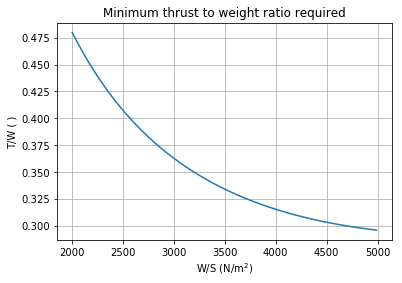

In [19]:
plt.plot(wingloadinglist_pa, twratio)
plt.ylabel("T/W ( )")
plt.xlabel("W/S (N/m$^2$)")
plt.title("Minimum thrust to weight ratio required")
plt.grid(True)
plt.show()